In [18]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist
import imageio
from scipy import stats

from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, ROICreator
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.analysis.cell_roi import RandomROISample

# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


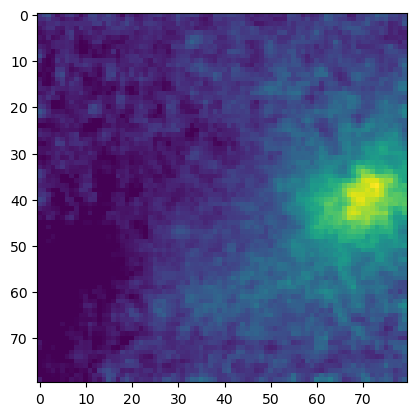

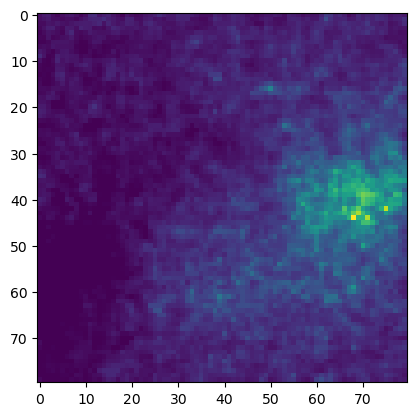

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mCherry-scnn1a-tg3-init/soma-vs-non-soma/03-18-24/converted_zda/"
target_recording = '04_01_01'
red_rois_filename = data_dir + 'ROIs-red_' + target_recording + '.dat'
# input files: *_amp.dat, *_snr.dat   # do not normalize!
cluster_SNRcutoff = 1
k_choice = 6  # none is auto

ROI_px_cutoff = 9

data = {}
for fn in ['_amp_map.dat', '_snr_map.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr




[[3140, 3141, 3220], [1916, 1915], [1834], [2388, 2468], [2788, 2868], [3186, 3185, 3187], [3345, 3344], [3182, 3181], [2637], [2712], [2874, 2954], [2313, 2312], [2065], [3350], [2767, 2766], [4029, 4030], [2923, 2843, 2842], [3255, 3254, 3334], [3258, 3259, 3178], [3419, 3499], [4300, 4380, 4381], [4605, 4525, 4606], [3728, 3808, 3727], [3975, 3974], [4209, 4208, 4128], [4212, 4131, 4132], [3880, 3881, 3800], [3796, 3795, 3876], [1888, 1808, 1889], [3240, 3239, 3320], [3161, 3162, 3242], [3483, 3484, 3564, 4432, 4431, 4511], [4978, 4977, 4897, 4827, 4907, 4987, 4906], [3235, 3234, 3154], [3312, 3313, 3393], [5407, 5406, 5487], [5168, 5088, 5089], [2606, 2607, 2687], [3085, 3005, 3006], [3014, 3013, 2933], [2937, 2936, 2856], [2774, 2773, 2693], [2942, 2941, 2861], [3943], [3492, 3493], [3814, 3815], [2211, 2212, 2291], [2454]] 48
[[[20, 39], [21, 39], [20, 40]], [[76, 23], [75, 23]], [[74, 22]], [[68, 29], [68, 30]], [[68, 34], [68, 35]], [[66, 39], [65, 39], [67, 39]], [[65, 41], [6

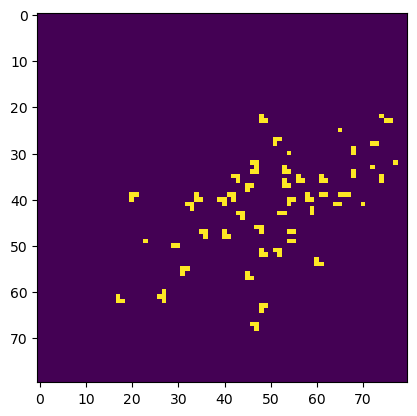

124.0


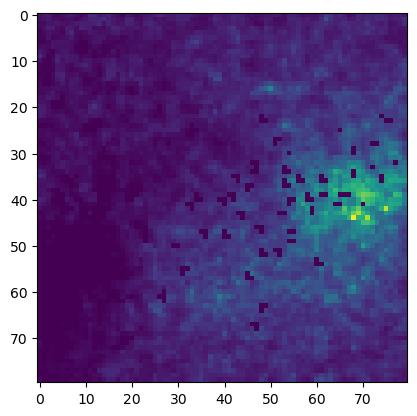

In [3]:
# open the ROI file and read the data
rfr = ROIFileReader(red_rois_filename)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
n, m = data['_amp_map.dat'].shape
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))

plt.imshow(data['_snr_map.dat'] * (1-red_roi_map))

In [4]:
# now sample pixels that are above the SNR and amplitude cutoffs but are NOT in the red ROIs
# and write them to a new ROI file
SNR_cutoff = 5
Amp_cutoff = 1.2

roi_sampler = RandomROISample(1)

# return list of lists of pairs (px)
# roi_list = roi_sampler.take_random_sample()

new_rois = []
nr_map = {}
while(len(new_rois) < 100):
    i, j = roi_sampler.get_random_point()
    if (j,i) not in nr_map \
        and data['_snr_map.dat'][i][j] > SNR_cutoff \
        and data['_amp_map.dat'][i][j] > Amp_cutoff \
        and red_roi_map[j][i] == 0:
        new_rois.append([j, i])
        nr_map[(j, i)] = 1
    if len(new_rois) > 99:
        break
print(len(new_rois))

# convert pixels to diode numbers
roi_cr = ROICreator(None)
new_rois = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois]
print(new_rois)

rfw = ROIFileWriter()
rfw.write_regions_to_dat(data_dir + 'ROIs-not-red_' 
                         + target_recording + '.dat',
               new_rois)


100
[[3598], [3340], [3117], [4390], [3599], [1331], [4058], [4392], [3103], [4925], [1912], [3819], [3510], [4068], [4684], [2789], [4386], [4378], [4301], [3263], [3194], [3746], [3915], [5589], [2155], [3824], [2145], [3745], [3269], [4864], [3109], [3591], [2470], [1668], [3590], [1994], [2478], [3025], [2540], [4940], [2554], [5119], [4371], [4308], [3659], [3197], [3351], [2793], [3350], [2317], [3507], [5117], [4222], [2555], [1916], [5022], [6381], [3910], [3575], [2864], [2307], [3748], [1358], [4064], [3830], [4393], [4229], [5104], [4382], [3584], [3997], [4537], [3436], [3900], [4774], [3414], [3111], [4460], [4630], [4783], [4769], [4136], [2635], [2154], [4858], [3423], [2543], [4146], [4070], [4221], [3898], [4928], [4770], [5359], [4545], [1665], [3275], [2393], [2948], [2395]]
Overwriting C:/Users/jjudge3/Desktop/Data/mCherry-scnn1a-tg3-init/soma-vs-non-soma/03-18-24/converted_zda/ROIs-not-red_04_01_01.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mCherry-scnn1

48
100


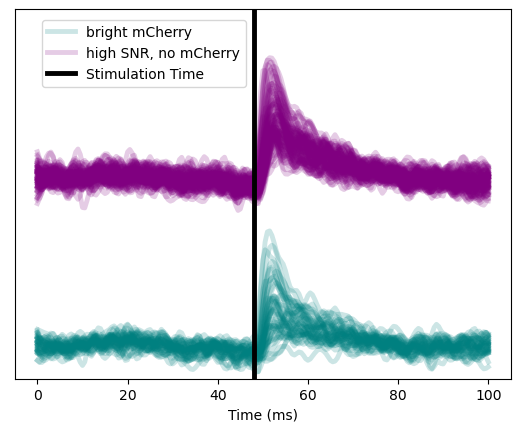

In [26]:
# plot traces for all red rois
trace_filename = data_dir + 'ROIs-red-traces_' + target_recording + '.dat'
n_traces = len(red_rois)
print(n_traces)
trace_data = pd.read_csv(trace_filename,
                         sep='\t',
                         header=0,
                         names=['Index'] + ['ROI' + str(i) for i in range(1,n_traces+1)])


plt.clf()
start_cut = 0
end_cut = 200
baseline = 0
t = None
j = 0
for i in range(1, n_traces+1):
    v1 = trace_data.loc[start_cut:end_cut, ['ROI' + str(i)]] + baseline * j
    j += 1
    if t is None:
        t = [(i+start_cut) * 0.5 for i in range(len(v1))]
    label = None
    if i == n_traces:
        label = "bright mCherry"
    plt.plot(t, v1, linewidth=3.5, alpha=.2, color='teal', label=label)
plt.yticks([])
plt.xlabel("Time (ms)")

trace_filename = data_dir + 'ROIs-not-red-traces_' + target_recording + '.dat'
n_traces = len(new_rois)
print(n_traces)
trace_sample = pd.read_csv(trace_filename,
                         sep='\t',
                         header=0,
                         names=['Index'] + ['ROI' + str(i) for i in range(1,n_traces+1)])

baseline = 5
t = None
j = 0
for i in range(1, n_traces+1):
    v1 = trace_sample.loc[start_cut:end_cut, ['ROI' + str(i)]] + baseline
    j += 1
    if t is None:
        t = [(i+start_cut) * 0.5 for i in range(len(v1))]
    label = None
    if i == n_traces:
        label = "high SNR, no mCherry"
    plt.plot(t, v1, linewidth=3.5, alpha=.2, color='purple', label=label)
#plt.plot(t, v1, label="hVOS manual", color='purple')
plt.axvline(x=48, label="Stimulation Time", color='black', linewidth=3.5)
plt.legend(bbox_to_anchor=(0.26, .99), loc='upper center')
plt.ylim([-1,10])
plt.savefig(data_dir + 'sample-traces.png', dpi=300)
plt.show()


Latency: t =  1.5323097021272585 p =  (2, 0.003395905081033185)
Half-width: t =  -1.5931345991854797 p =  (2, 0.003395905081033185)
SNR: t =  -3.0031785154778188 p =  (2, 0.003395905081033185)


<Figure size 640x480 with 0 Axes>

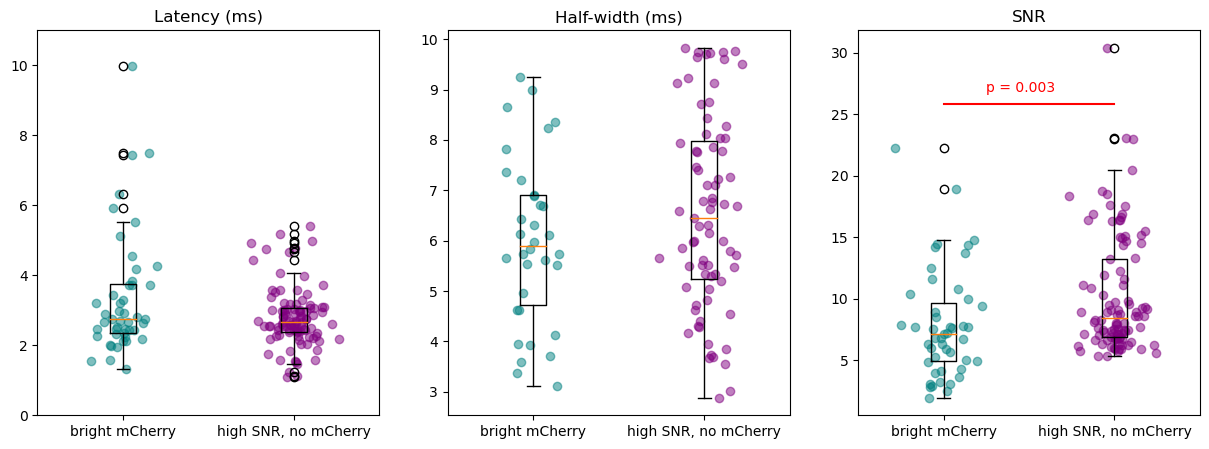

In [25]:
# compare hw, latency, and snr of bright mCherry versus high SNR, no mCherry
# hw, latency, and snr are in:
#  04_01_01_latency.dat, 04_01_01_hw.dat, 04_01_01_snr.dat (for bright mCherry)
# and 04_01_01_notred_latency.dat, 04_01_01_notred_hw.dat, 04_01_01_notred_snr.dat (for high SNR, no mCherry)
# these files are in the same directory as the traces files
# they are two-column tab-separated files with the first column being the ROI number and the second column being the value
# for hw and latency, the value is in ms
# for snr, the value is the SNR

# read the files
latency_filename = data_dir + target_recording + '_latency.dat'
hw_filename = data_dir + target_recording + '_hw.dat'
snr_filename = data_dir + target_recording + '_snr.dat'

latency_data = pd.read_csv(latency_filename,
                            sep='\t',
                            header=None,
                            names=['Index', 'Value'])
hw_data = pd.read_csv(hw_filename,
                            sep='\t',
                            header=None,
                            names=['Index', 'Value'])
snr_data = pd.read_csv(snr_filename,
                            sep='\t',
                            header=None,
                            names=['Index', 'Value'])
latency_data = latency_data.set_index('Index')
hw_data = hw_data.set_index('Index')
snr_data = snr_data.set_index('Index')

latency_filename = data_dir + target_recording + '_notred_latency.dat'
hw_filename = data_dir + target_recording + '_notred_hw.dat'
snr_filename = data_dir + target_recording + '_notred_snr.dat'

latency_data_sample = pd.read_csv(latency_filename,
                            sep='\t',
                            header=None,
                            names=['Index', 'Value'])       
hw_data_sample = pd.read_csv(hw_filename,
                            sep='\t',
                            header=None,
                            names=['Index', 'Value'])       
snr_data_sample = pd.read_csv(snr_filename,
                            sep='\t',
                            header=None,
                            names=['Index', 'Value'])       

latency_data_sample = latency_data_sample.set_index('Index')
hw_data_sample = hw_data_sample.set_index('Index')
snr_data_sample = snr_data_sample.set_index('Index')

# filter to positive values
latency_data = latency_data[latency_data['Value'] > 0]
hw_data = hw_data[hw_data['Value'] > 0]
snr_data = snr_data[snr_data['Value'] > 0]
latency_data_sample = latency_data_sample[latency_data_sample['Value'] > 0]
hw_data_sample = hw_data_sample[hw_data_sample['Value'] > 0]
snr_data_sample = snr_data_sample[snr_data_sample['Value'] > 0]

# subtract time of stim from latency
latency_data['Value'] = latency_data['Value'] - 48
latency_data_sample['Value'] = latency_data_sample['Value'] - 48

# plot the data: 1-D boxplots of latency, hw, and snr comparing bright mCherry to high SNR, no mCherry
# make 3 subplots
plt.clf()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# scatter plot the data with x-jitter to show the distribution
x_jitter = np.random.normal(0, 0.1, len(latency_data['Value']))
axs[0].scatter(x_jitter + 1, latency_data['Value'], alpha=0.5, color='teal')
x_jitter = np.random.normal(0, 0.1, len(latency_data_sample['Value']))
axs[0].scatter(x_jitter + 2, latency_data_sample['Value'], alpha=0.5, color='purple')
x_jitter = np.random.normal(0, 0.1, len(hw_data['Value']))
axs[1].scatter(x_jitter + 1, hw_data['Value'], alpha=0.5, color='teal')
x_jitter = np.random.normal(0, 0.1, len(hw_data_sample['Value']))
axs[1].scatter(x_jitter + 2, hw_data_sample['Value'], alpha=0.5, color='purple')
x_jitter = np.random.normal(0, 0.1, len(snr_data['Value']))
axs[2].scatter(x_jitter + 1, snr_data['Value'], alpha=0.5, color='teal')
x_jitter = np.random.normal(0, 0.1, len(snr_data_sample['Value']))
axs[2].scatter(x_jitter + 2, snr_data_sample['Value'], alpha=0.5, color='purple')

# boxplots
axs[0].boxplot([latency_data['Value'], latency_data_sample['Value']])
axs[0].set_xticklabels(['bright mCherry', 'high SNR, no mCherry'])
axs[0].set_title("Latency (ms)")
axs[1].boxplot([hw_data['Value'], hw_data_sample['Value']])
axs[1].set_xticklabels(['bright mCherry', 'high SNR, no mCherry'])
axs[1].set_title("Half-width (ms)")
axs[2].boxplot([snr_data['Value'], snr_data_sample['Value']])
axs[2].set_xticklabels(['bright mCherry', 'high SNR, no mCherry'])
axs[2].set_title("SNR")

# significance testing to compare bright mCherry to high SNR, no mCherry
# latency
t, p_lat = stats.ttest_ind(latency_data['Value'], latency_data_sample['Value'], equal_var=False)
print("Latency: t = ", t, "p = ", p)
# hw
t, p_hw = stats.ttest_ind(hw_data['Value'], hw_data_sample['Value'], equal_var=False)
print("Half-width: t = ", t, "p = ", p)
# snr
t, p_snr = stats.ttest_ind(snr_data['Value'], snr_data_sample['Value'], equal_var=False)
print("SNR: t = ", t, "p = ", p)

# mark significance on the plot
for p in enumerate([p_lat, p_hw, p_snr]):
    if p[1] < 0.05:

        # add p-value to plot
        axs[p[0]].text(1.25, 26.8, "p = " + str(p[1])[:5], fontsize=10, color='red')

        # add bars  to plot
        axs[p[0]].plot([1, 2], [25.85, 25.85], color='red')

axs[0].set_ylim([0, 11])
plt.savefig(data_dir + 'red-vs-notred-boxplots.png', dpi=300)
plt.show()


[[3140, 3141, 3220], [1916, 1915], [1834], [2388, 2468], [2788, 2868], [3186, 3185, 3187], [3345, 3344], [3182, 3181], [2637], [2712], [2874, 2954], [2313, 2312], [2065], [3350], [2767, 2766], [4029, 4030], [2923, 2843, 2842], [3255, 3254, 3334], [3258, 3259, 3178], [3419, 3499], [4300, 4380, 4381], [4605, 4525, 4606], [3728, 3808, 3727], [3975, 3974], [4209, 4208, 4128], [4212, 4131, 4132], [3880, 3881, 3800], [3796, 3795, 3876], [1888, 1808, 1889], [3240, 3239, 3320], [3161, 3162, 3242], [3483, 3484, 3564, 4432, 4431, 4511], [4978, 4977, 4897, 4827, 4907, 4987, 4906], [3235, 3234, 3154], [3312, 3313, 3393], [5407, 5406, 5487], [5168, 5088, 5089], [2606, 2607, 2687], [3085, 3005, 3006], [3014, 3013, 2933], [2937, 2936, 2856], [2774, 2773, 2693], [2942, 2941, 2861], [3943], [3492, 3493], [3814, 3815], [2211, 2212, 2291], [2454]] 48
[[[20, 39], [21, 39], [20, 40]], [[76, 23], [75, 23]], [[74, 22]], [[68, 29], [68, 30]], [[68, 34], [68, 35]], [[66, 39], [65, 39], [67, 39]], [[65, 41], [6

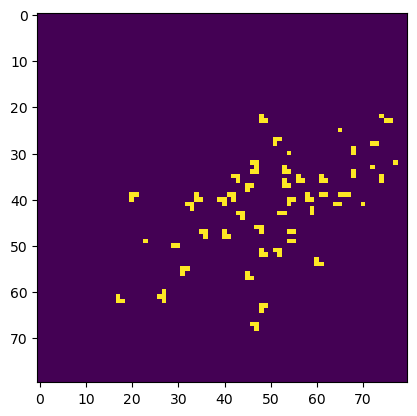

124.0


In [6]:
# read in red labels 
rfr = ROIFileReader(red_rois_filename)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))